# Covid-19 Predictive Modelling

In [42]:
#import libraries  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [43]:
# Read each CSV file
df1 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\country_wise_latest.csv')
df2 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\covid_19_clean_complete.csv')
df3 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\day_wise.csv')
df4 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\full_grouped.csv')
df5 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\usa_county_wise.csv')
df6 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\worldometer_data.csv')

# Concatenate all DataFrames into one
# merged_df = pd.concat([df1, df2, df3, df4,df5,df6], ignore_index=True)
# merged_df

In [44]:
df3 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\day_wise.csv')
print("Original Data:")
print(df3)

Original Data:
           Date  Confirmed  Deaths  Recovered   Active  New cases  New deaths  \
0    22/01/2020        555      17         28      510          0           0   
1    23/01/2020        654      18         30      606         99           1   
2    24/01/2020        941      26         36      879        287           8   
3    25/01/2020       1434      42         39     1353        493          16   
4    26/01/2020       2118      56         52     2010        684          14   
..          ...        ...     ...        ...      ...        ...         ...   
183  23/07/2020   15510481  633506    8710969  6166006     282756        9966   
184  24/07/2020   15791645  639650    8939705  6212290     281164        6144   
185  25/07/2020   16047190  644517    9158743  6243930     255545        4867   
186  26/07/2020   16251796  648621    9293464  6309711     204606        4104   
187  27/07/2020   16480485  654036    9468087  6358362     228693        5415   

     New rec

# Data Preprocessing

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(df3):
    #Identify numeric and categorical features
    numeric_features = df3.select_dtypes(include=['float', 'int']).columns
    categorical_features = df3.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    df3[numeric_features] = df3[numeric_features].fillna(df3[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = df3[feature].quantile(0.25)
        Q3 = df3[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        df3[feature] = np.where((df3[feature] < lower_bound) | (df3[feature] > upper_bound),
                                 df3[feature].mean(), df3[feature])

    #Normalize numeric features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df3[numeric_features])
    df3[numeric_features] = scaler.transform(df3[numeric_features])

    #Handle missing values in categorical features
    df3[categorical_features] = df3[categorical_features].fillna(df3[categorical_features].mode().iloc[0])
    
    return df3

In [9]:
cleaned_df3 = data_preprocessing_pipeline(df3)

print("Preprocessed Data:")
print(cleaned_df3)

Preprocessed Data:
           Date  Confirmed    Deaths  Recovered    Active  New cases  \
0    22/01/2020  -0.928580 -1.061675  -0.802974 -1.073942  -1.168803   
1    23/01/2020  -0.928559 -1.061671  -0.802973 -1.073893  -1.167485   
2    24/01/2020  -0.928498 -1.061634  -0.802971 -1.073754  -1.164982   
3    25/01/2020  -0.928394 -1.061560  -0.802969 -1.073513  -1.162238   
4    26/01/2020  -0.928250 -1.061496  -0.802964 -1.073178  -1.159695   
..          ...        ...       ...        ...       ...        ...   
183  23/07/2020   2.339890  1.852945   0.096620  2.064634   2.596519   
184  24/07/2020   2.399141  1.881213   0.096620  2.088195   2.575319   
185  25/07/2020   2.452993  1.903606   0.096620  2.104301   2.234163   
186  26/07/2020   2.496110  1.922488   0.096620  2.137787   1.555834   
187  27/07/2020   2.544303  1.947402   0.096620  2.162553   1.876588   

     New deaths  New recovered  Deaths / 100 Cases  Recovered / 100 Cases  \
0     -1.374498      -0.943917         

In [10]:
cleaned_df3.isna().sum()

Date                      0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
No. of countries          0
dtype: int64

In [11]:
# Standardize Date format
cleaned_df3["Date"] = pd.to_datetime(cleaned_df3["Date"], format='%d/%m/%Y', errors='coerce')
cleaned_df3

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,-0.928580,-1.061675,-0.802974,-1.073942,-1.168803,-1.374498,-0.943917,-1.143020,-1.812407,0.686102,-2.128399
1,2020-01-23,-0.928559,-1.061671,-0.802973,-1.073893,-1.167485,-1.374103,-0.943877,-1.339803,-1.840867,0.686102,-2.097631
2,2020-01-24,-0.928498,-1.061634,-0.802971,-1.073754,-1.164982,-1.371338,-0.943797,-1.333456,-1.887888,0.686102,-2.082247
3,2020-01-25,-0.928394,-1.061560,-0.802969,-1.073513,-1.162238,-1.368177,-0.943857,-1.225542,-1.956564,0.686102,-2.051479
4,2020-01-26,-0.928250,-1.061496,-0.802964,-1.073178,-1.159695,-1.368967,-0.943657,-1.409630,-1.972650,0.686102,-2.020711
...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-07-23,2.339890,1.852945,0.096620,2.064634,2.596519,2.563111,2.444955,-0.495538,1.349753,-1.203360,0.656113
184,2020-07-24,2.399141,1.881213,0.096620,2.088195,2.575319,1.053022,0.061719,-0.514582,1.377595,-1.217370,0.656113
185,2020-07-25,2.452993,1.903606,0.096620,2.104301,2.234163,0.548474,0.061719,-0.533625,1.406055,-1.232655,0.656113
186,2020-07-26,2.496110,1.922488,0.096620,2.137787,1.555834,0.247010,1.746210,-0.552669,1.412861,-1.240297,0.656113


# Exploratory Data Analysis

In [12]:
cleaned_df3['Daily Growth Rate (Confirmed)'] = (cleaned_df3['New cases'] / cleaned_df3['Confirmed']) * 100
cleaned_df3['Daily Growth Rate (Confirmed)']

0      125.870014
1      125.730866
2      125.469427
3      125.187989
4      124.933424
          ...    
183    110.967546
184    107.343370
185     91.079070
186     62.330323
187     73.756481
Name: Daily Growth Rate (Confirmed), Length: 188, dtype: float64

In [13]:
cleaned_df3['Daily Growth Rate (Deaths)'] = (cleaned_df3['New deaths'] / cleaned_df3['Deaths']) * 100
cleaned_df3['Daily Growth Rate (Deaths)']

0      129.465055
1      129.428401
2      129.172372
3      128.883576
4      128.965840
          ...    
183    138.326329
184     55.975707
185     28.812382
186     12.848433
187     39.282666
Name: Daily Growth Rate (Deaths), Length: 188, dtype: float64

In [14]:
cleaned_df3['Daily Growth Rate (Recovered)'] = (cleaned_df3['New recovered'] / cleaned_df3['Recovered']) * 100
cleaned_df3['Daily Growth Rate (Recovered)']

0       117.552575
1       117.547729
2       117.538164
3       117.545816
4       117.521776
          ...     
183    2530.472889
184      63.877486
185      63.877486
186    1807.287819
187    2631.925051
Name: Daily Growth Rate (Recovered), Length: 188, dtype: float64

In [15]:
# Group the data by Date and sum up the values for each date
daily_trends = cleaned_df3.groupby('Date').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()
daily_trends

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,-0.928580,-1.061675,-0.802974
1,2020-01-23,-0.928559,-1.061671,-0.802973
2,2020-01-24,-0.928498,-1.061634,-0.802971
3,2020-01-25,-0.928394,-1.061560,-0.802969
4,2020-01-26,-0.928250,-1.061496,-0.802964
...,...,...,...,...
183,2020-07-23,2.339890,1.852945,0.096620
184,2020-07-24,2.399141,1.881213,0.096620
185,2020-07-25,2.452993,1.903606,0.096620
186,2020-07-26,2.496110,1.922488,0.096620


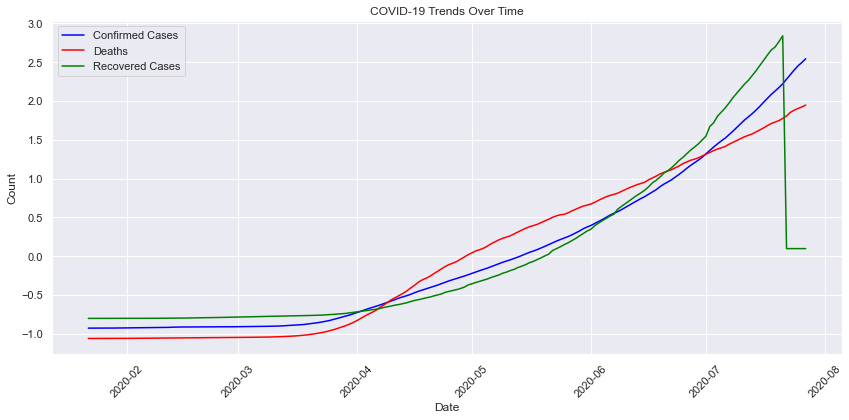

In [16]:
# Plotting the line plot for confirmed cases, deaths, and recoveries over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_trends, x='Date', y='Confirmed', label='Confirmed Cases', color='blue')
sns.lineplot(data=daily_trends, x='Date', y='Deaths', label='Deaths', color='red')
sns.lineplot(data=daily_trends, x='Date', y='Recovered', label='Recovered Cases', color='green')

plt.title('COVID-19 Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Calculate the Mortality Ratio (Death rate / Confirmed cases rate) for each day
daily_trends['Mortality Ratio'] = (daily_trends['Deaths'] / daily_trends['Confirmed']) * 100
daily_trends['Mortality Ratio']


0      114.333246
1      114.335319
2      114.338803
3      114.343669
4      114.354485
          ...    
183     79.189404
184     78.411940
185     77.603383
186     77.019335
187     76.539686
Name: Mortality Ratio, Length: 188, dtype: float64

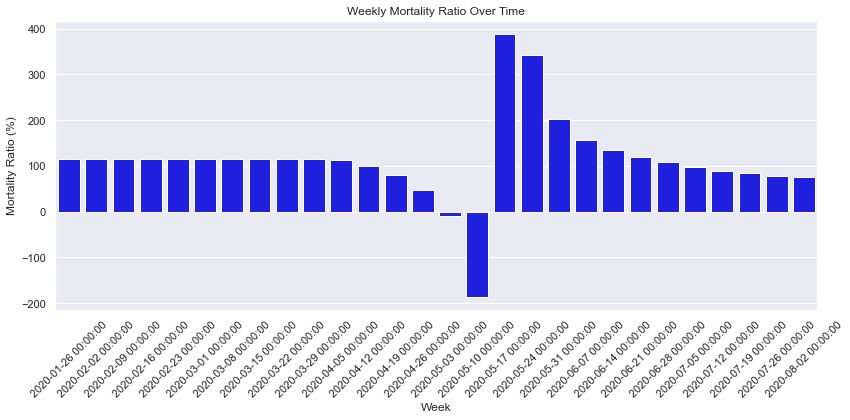

In [18]:
# Resample daily data into weekly averages
weekly_trends = daily_trends.set_index('Date').resample('W').mean()

# Plotting weekly mortality ratio trends
plt.figure(figsize=(12, 6))
sns.barplot(x=weekly_trends.index, y=weekly_trends['Mortality Ratio'], color='blue')

plt.title('Weekly Mortality Ratio Over Time')
plt.xlabel('Week')
plt.ylabel('Mortality Ratio (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


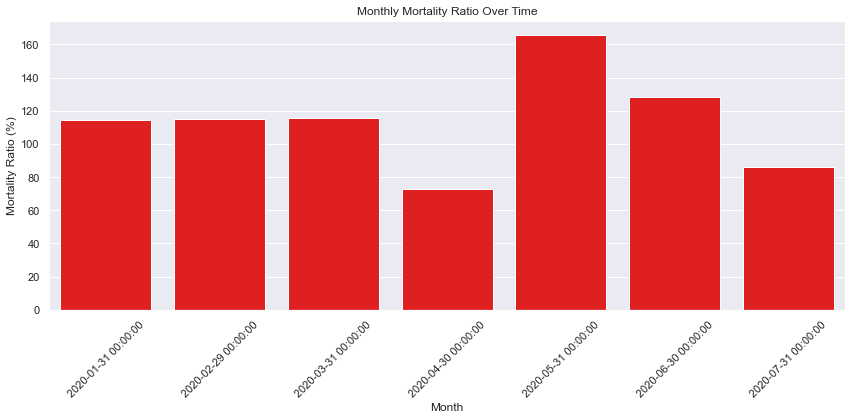

In [19]:
monthly_trends = daily_trends.set_index('Date').resample('M').mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_trends.index, y=monthly_trends['Mortality Ratio'], color='red')

plt.title('Monthly Mortality Ratio Over Time')
plt.xlabel('Month')
plt.ylabel('Mortality Ratio (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# Time series model

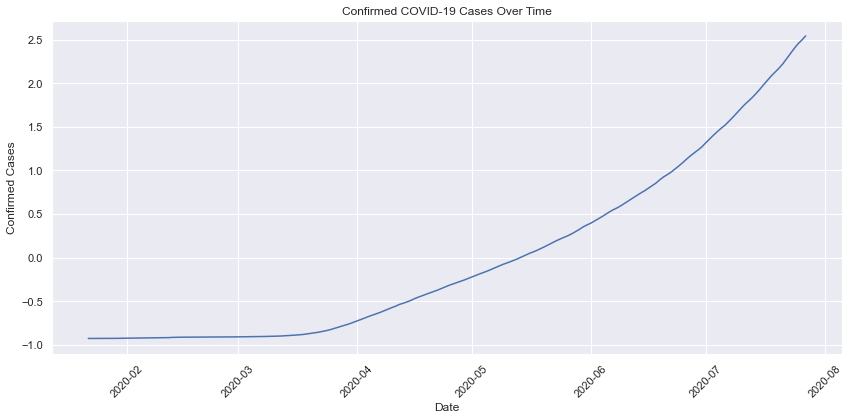

In [20]:
# Group data by Date and sum the values
daily_trends = cleaned_df3.groupby('Date').agg({'Confirmed': 'sum'}).reset_index()

# Set the Date as the index for time series forecasting
daily_trends.set_index('Date', inplace=True)

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(daily_trends.index, daily_trends['Confirmed'], label='Confirmed Cases')
plt.title('Confirmed COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


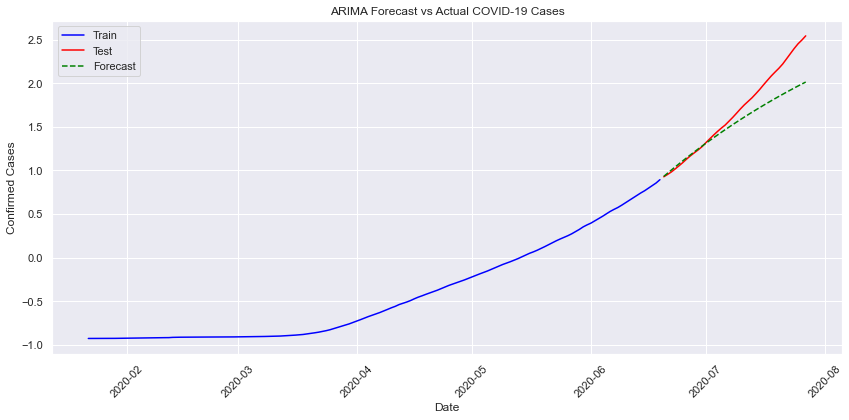

RMSE: 0.2302


In [21]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(daily_trends) * 0.8)
train, test = daily_trends[:train_size], daily_trends[train_size:]

# Fit ARIMA model (order is p=1, d=1, q=1 for simplicity)
arima_model = ARIMA(train, order=(2, 1, 1))
arima_fit = arima_model.fit()

# Make predictions
forecast = arima_fit.forecast(steps=len(test))
test['Forecast'] = forecast

# Plot the forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Confirmed'], label='Train', color='blue')
plt.plot(test.index, test['Confirmed'], label='Test', color='red')
plt.plot(test.index, test['Forecast'], label='Forecast', color='green', linestyle='--')

plt.title('ARIMA Forecast vs Actual COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate RMSE (Root Mean Squared Error) for evaluation
rmse = np.sqrt(mean_squared_error(test['Confirmed'], test['Forecast']))
print(f'RMSE: {rmse:.4f}')


In [22]:
''''The Root Mean Square Error (RMSE) of 0.2302 indicates the average difference between the predicted values 
and the actual values, expressed in the same units as the dependent variable.'''

''''Since the target variable is between more than 2, an RMSE of 0.2  suggest a extremely good performance.'''

"'Since the target variable is between more than 2, an RMSE of 0.2  suggest a extremely good performance."

In [45]:
df6 = pd.read_csv(r'C:\Users\USER\Desktop\Tedprime\3mtt\worldometer_data.csv')
print("Original Data:")
print(df6)

Original Data:
     Country/Region Continent  Population  TotalCases  NewCases  TotalDeaths  \
0       Afghanistan      Asia  39009447.0       36896       NaN       1298.0   
1           Albania    Europe   2877470.0        6016       NaN        188.0   
2           Algeria    Africa  43926079.0       33626       NaN       1273.0   
3           Andorra    Europe     77278.0         944       NaN         52.0   
4            Angola    Africa  32956300.0        1483       NaN         64.0   
..              ...       ...         ...         ...       ...          ...   
204         Vietnam      Asia  97425470.0         747       NaN         10.0   
205  Western Sahara    Africa    598682.0          10       NaN          1.0   
206           Yemen      Asia  29886897.0        1768       NaN        508.0   
207          Zambia    Africa  18430129.0        7164       NaN        199.0   
208        Zimbabwe    Africa  14883803.0        4339       NaN         84.0   

     NewDeaths  TotalRec

# Data Preprocessing

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(df6):
    #Identify numeric and categorical features
    numeric_features = df6.select_dtypes(include=['float', 'int']).columns
    categorical_features = df6.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    df6[numeric_features] = df6[numeric_features].fillna(df6[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = df6[feature].quantile(0.25)
        Q3 = df6[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        df6[feature] = np.where((df6[feature] < lower_bound) | (df6[feature] > upper_bound),
                                 df6[feature].mean(), df6[feature])

    #Normalize numeric features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df6[numeric_features])
    df6[numeric_features] = scaler.transform(df6[numeric_features])

    #Handle missing values in categorical features
    df6[categorical_features] = df6[categorical_features].fillna(df6[categorical_features].mode().iloc[0])
    
    return df6

In [25]:
cleaned_df6 = data_preprocessing_pipeline(df6)

print("Preprocessed Data:")
print(cleaned_df6)

Preprocessed Data:
     Country/Region Continent  Population  TotalCases  NewCases  TotalDeaths  \
0       Afghanistan      Asia    1.693076    0.407043       0.0     0.100572   
1           Albania    Europe   -0.709867   -0.525236       0.0    -0.604718   
2           Algeria    Africa    2.020055    0.308321       0.0     0.084687   
3           Andorra    Europe   -0.896093   -0.678362       0.0    -0.691132   
4            Angola    Africa    1.290514   -0.662089       0.0    -0.683508   
..              ...       ...         ...         ...       ...          ...   
204         Vietnam      Asia    1.121538   -0.684309       0.0    -0.717819   
205  Western Sahara    Africa   -0.861417   -0.706560       0.0    -0.723538   
206           Yemen      Asia    1.086385   -0.653485       0.0    -0.401391   
207          Zambia    Africa    0.324457   -0.490578       0.0    -0.597729   
208        Zimbabwe    Africa    0.088609   -0.575866       0.0    -0.670800   

     NewDeaths  Tota

In [26]:
cleaned_df6.isna().sum()

Country/Region      0
Continent           0
Population          0
TotalCases          0
NewCases            0
TotalDeaths         0
NewDeaths           0
TotalRecovered      0
NewRecovered        0
ActiveCases         0
Serious,Critical    0
Tot Cases/1M pop    0
Deaths/1M pop       0
TotalTests          0
Tests/1M pop        0
WHO Region          0
dtype: int64

In [27]:
# Standardize Country names
cleaned_df6["Country/Region"] = cleaned_df6["Country/Region"].str.title()
cleaned_df6

,Country/Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,WHO Region
0,Afghanistan,Asia,1.693076,0.407043,0.0,0.100572,0.0,0.476249,0.0,0.375959,-1.056014,-0.507648,-0.413661,-0.702416,-1.078017,EasternMediterranean
1,Albania,Europe,-0.709867,-0.525236,0.0,-0.604718,0.0,-0.563119,0.0,-0.366120,-1.087191,0.023091,0.192814,-0.779066,-0.833332,Europe
2,Algeria,Africa,2.020055,0.308321,0.0,0.084687,0.0,0.357032,0.0,0.308611,-0.954685,-0.591082,-0.489470,1.254150,0.699898,Africa
3,Andorra,Europe,-0.896093,-0.678362,0.0,-0.691132,0.0,-0.669736,0.0,-0.639385,-1.172931,0.535300,0.831150,-0.831629,-0.071730,Europe
4,Angola,Africa,1.290514,-0.662089,0.0,-0.683508,0.0,-0.683847,0.0,-0.551927,-1.098883,-0.925286,-1.001182,-0.740666,-1.085682,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Vietnam,Asia,1.121538,-0.684309,0.0,-0.717819,0.0,-0.689712,0.0,-0.609953,0.905832,-0.942436,-1.037192,-0.117747,-1.020635,WesternPacific
205,Western Sahara,Africa,-0.861417,-0.706560,0.0,-0.723538,0.0,-0.707306,0.0,-0.645983,0.905832,-0.938264,-1.001182,1.254150,0.699898,Africa
206,Yemen,Asia,1.086385,-0.653485,0.0,-0.401391,0.0,-0.666528,0.0,-0.608172,0.905832,-0.918796,-0.716898,-0.837042,-1.128387,EasternMediterranean
207,Zambia,Africa,0.324457,-0.490578,0.0,-0.597729,0.0,-0.442573,0.0,-0.522600,0.905832,-0.765832,-0.830611,-0.702549,-1.021767,Africa


In [28]:
cleaned_df6 = cleaned_df6.drop(['Continent'], axis = 1)

In [29]:
# data_dummy = cleaned_data.copy()
# data_dummy[ 'WHO Region'] = data_dummy[ 'WHO Region'].map({'EasternMediterranean': 1,
                                                                           #  'Europe': 2,'Africa': 3,
                                                                           # 'Americas': 4,
                                                                           # 'WesternPacific': 5,'South-EastAsia': 6})
# data_dummy

# Exploratory Data Analysis

In [63]:
# Looking at the Death cases by WHO Region
DeathcasesSum = df6.groupby('WHO Region')[["TotalDeaths"]].sum()

DeathcasesSumSorted = DeathcasesSum.sort_values('TotalDeaths', ascending = False)
DeathcasesSumSorted

,TotalDeaths
WHO Region,
Americas,384637.0
Europe,215564.0
South-EastAsia,50624.0
EasternMediterranean,42376.0
Africa,15538.0
WesternPacific,3975.0


In [64]:
# Looking at the top 15 country by Death cases

DeathcasesSum = df6.groupby('Country/Region')[["TotalDeaths"]].sum()

DeathcasesSumSorted = DeathcasesSum.sort_values('TotalDeaths', ascending = False)[:15]
DeathcasesSumSorted

,TotalDeaths
Country/Region,
USA,162804.0
Brazil,98644.0
Mexico,50517.0
UK,46413.0
India,41638.0
Italy,35187.0
France,30312.0
Spain,28500.0
Peru,20424.0


In [32]:
cleaned_df6['Cases per 100K Population'] = (cleaned_df6['TotalCases'] / cleaned_df6['Population']) * 1e5
cleaned_df6['Cases per 100K Population']

0       24041.646092
1       73990.776569
2       15262.989772
3       75702.192231
4      -51304.308871
           ...      
204    -61015.257914
205     82022.958232
206    -60152.276675
207   -151199.796359
208   -649891.566111
Name: Cases per 100K Population, Length: 209, dtype: float64

In [33]:
cleaned_df6['Deaths per 100K Population'] = (cleaned_df6['TotalDeaths'] / cleaned_df6['Population']) * 1e5
cleaned_df6['Deaths per 100K Population']

0        5940.201750
1       85187.549112
2        4192.322633
3       77127.320130
4      -52963.983430
           ...      
204    -64003.085646
205     83993.882237
206    -36947.452058
207   -184224.689159
208   -757029.297744
Name: Deaths per 100K Population, Length: 209, dtype: float64

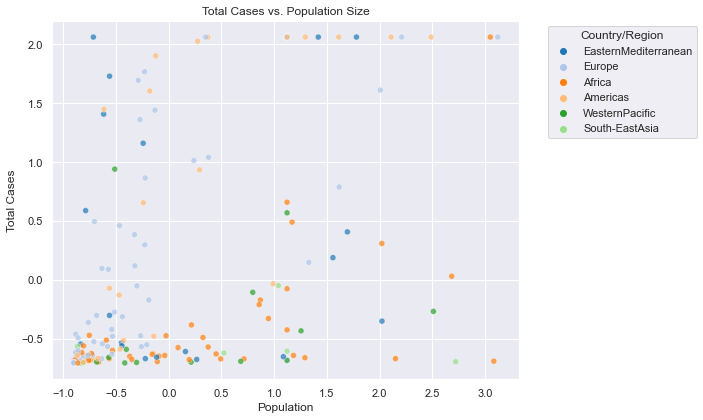

In [34]:
# Plotting the Total cases vs. population for each WHO Region
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Population', y='TotalCases', data=cleaned_df6, hue='WHO Region', palette='tab20', alpha=0.7)

plt.title('Total Cases vs. Population Size')
plt.xlabel('Population')
plt.ylabel('Total Cases')
plt.legend(title='Country/Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

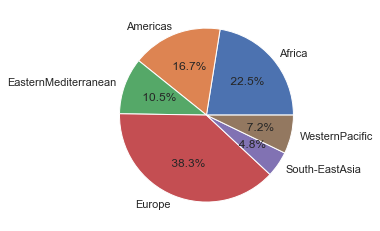

In [35]:
pp=cleaned_df6.groupby('WHO Region')['TotalDeaths'].count()
plt.pie(pp,labels=pp.index,autopct='%5.1f%%')
plt.show()

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Apply standardization
numerical_columns = ['Population', 'TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases',
       'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop', 'TotalTests',
       'Tests/1M pop']

cleaned_df6[numerical_columns] = scaler.fit_transform(cleaned_df6[numerical_columns])

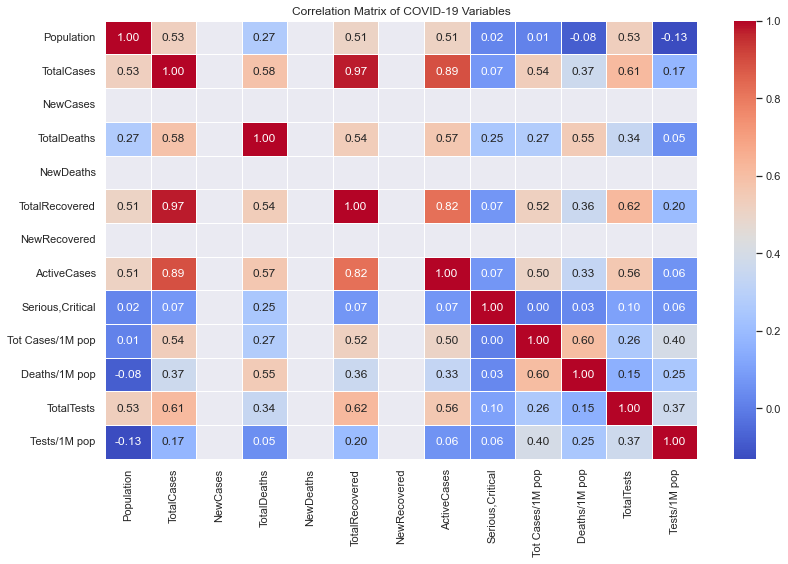

,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop
Population,1.000000,0.526558,NaN,0.267024,NaN,0.506181,NaN,0.510852,0.022204,0.011851,-0.084778,0.530783,-0.130429
TotalCases,0.526558,1.000000,NaN,0.582017,NaN,0.974828,NaN,0.892121,0.073742,0.535939,0.368395,0.613944,0.174788
NewCases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalDeaths,0.267024,0.582017,NaN,1.000000,NaN,0.539898,NaN,0.566402,0.246516,0.273794,0.545509,0.344400,0.047414
NewDeaths,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalRecovered,0.506181,0.974828,NaN,0.539898,NaN,1.000000,NaN,0.819854,0.070553,0.523052,0.359713,0.619287,0.200282
NewRecovered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActiveCases,0.510852,0.892121,NaN,0.566402,NaN,0.819854,NaN,1.000000,0.071041,0.502072,0.333417,0.559292,0.060017
"Serious,Critical",0.022204,0.073742,NaN,0.246516,NaN,0.070553,NaN,0.071041,1.000000,0.003300,0.030565,0.104350,0.058597
Tot Cases/1M pop,0.011851,0.535939,NaN,0.273794,NaN,0.523052,NaN,0.502072,0.003300,1.000000,0.603653,0.258502,0.397829


In [37]:
# Calculate correlation matrix for numerical columns
correlation_matrix = cleaned_df6[numerical_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix of COVID-19 Variables')
plt.tight_layout()
plt.show()

correlation_matrix

In [163]:
# Create a binary target variable for classification (1 if deaths increased, 0 if not
# To predict whether the number of death will increase compared to the previous day.
cleaned_df6['Death Increase'] = (cleaned_df6['TotalDeaths'] > cleaned_df6['TotalDeaths'].shift(1)).astype(int)
cleaned_df6['Death Increase']

0      0
1      0
2      1
3      0
4      1
      ..
204    0
205    0
206    1
207    0
208    0
Name: Death Increase, Length: 209, dtype: int32

In [164]:
cleaned_df6['Death Increase'].unique() 

array([0, 1])

In [219]:
# Drop rows with NaN in the target or features (especially for the first row)
cleaned_df6.dropna(subset=['Death Increase'], inplace=True)

# Features and target variable
features = ['TotalCases','ActiveCases','Population','Serious,Critical','TotalRecovered']
X = cleaned_df6[features]
y = cleaned_df6['Death Increase']

In [199]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (optional but often beneficial for many ML models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [200]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [201]:
# Split the data into training and testing sets
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [202]:
# Create an XGBoost classifier and fit it to the training data
xgb_model  = xgb.XGBClassifier()
xgb_model .fit(X_train_scaled, y_train)

# Make predictions on the validation data
predictions = xgb_model.predict(X_valid_scaled)

In [203]:
 # Evaluate the model
accuracy = accuracy_score(y_valid, predictions)
print(f'Accuracy on validation set: {accuracy:.2f}')
print(classification_report(y_valid, predictions))

Accuracy on validation set: 0.68
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.65      0.69      0.67        16

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.68        34
weighted avg       0.68      0.68      0.68        34



In [204]:
# Use the trained model to make predictions on the test data
X_test_scaled = scaler.transform(X_test)
predictions_test = xgb_model.predict(X_test_scaled)

In [205]:
# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, predictions_test)
print(f'Accuracy on test set: {accuracy_test:.2f}')
print(classification_report(y_test, predictions_test))

Accuracy on test set: 0.62
              precision    recall  f1-score   support

           0       0.54      0.72      0.62        18
           1       0.72      0.54      0.62        24

    accuracy                           0.62        42
   macro avg       0.63      0.63      0.62        42
weighted avg       0.64      0.62      0.62        42



In [212]:
def plot_confusion_matrix(model, X_test, y_test, classes=None, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plotting confusion matrix.

    model: Trained classifier
    X_test: Test features
    y_test: True labels of the test set
    classes: List of class names (default None)
    normalize: Whether to normalize the confusion matrix (default False)
    title: Title of the plot (default 'Confusion matrix')
    cmap: Color map for the plot (default plt.cm.Blues)
    """

     # Generate predictions
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    if classes is None:
        classes = np.unique(y_test)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


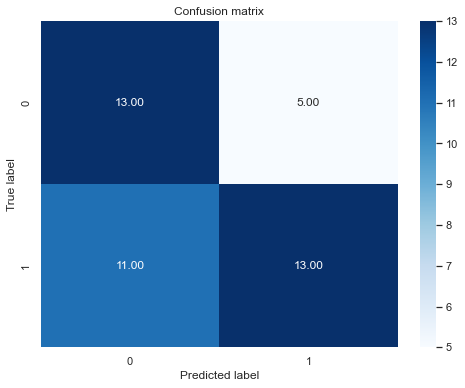

In [207]:
# Plot confusion matrix for test set
plot_confusion_matrix(xgb_model, X_test_scaled, y_test)

In [213]:
# hyperparameters 
xgb_model_tuned = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    learning_rate=0.1,  # Example learning rate
    n_estimators=100,   # Number of boosting rounds
    max_depth=6,        # Depth of the trees
    subsample=0.8,      # Fraction of samples to be used for each tree
    colsample_bytree=0.8  # Fraction of features used for each tree
)

# Train the model with tuned hyperparameters
xgb_model_tuned.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [214]:
# Split the data into training and testing sets
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=42)
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [215]:
# Create an XGBoost classifier and fit it to the training data
xgb_model_tuned = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    learning_rate=0.1,  # Example learning rate
    n_estimators=100,   # Number of boosting rounds
    max_depth=6,        # Depth of the trees
    subsample=0.8,      # Fraction of samples to be used for each tree
    colsample_bytree=0.8  # Fraction of features used for each tree
) 
xgb_model_tuned.fit(X_train_scaled, y_train)
# Make predictions on the validation data
prediction = xgb_model_tuned.predict(X_valid_scaled)

In [216]:
# Evaluate the model
accuracy = accuracy_score(y_valid, prediction)
print(f'Accuracy on validation set: {accuracy:.2f}')
print(classification_report(y_valid, prediction))

Accuracy on validation set: 0.68
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.65      0.69      0.67        16

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.68        34
weighted avg       0.68      0.68      0.68        34



In [217]:
# Use the trained model to make predictions on the test data
X_test_scaled = scaler.transform(X_test)
prediction_test = xgb_model_tuned.predict(X_test_scaled)

In [218]:
# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, prediction_test)
print(f'Accuracy on test set: {accuracy_test:.2f}')
print(classification_report(y_test, prediction_test))

Accuracy on test set: 0.71
              precision    recall  f1-score   support

           0       0.64      0.78      0.70        18
           1       0.80      0.67      0.73        24

    accuracy                           0.71        42
   macro avg       0.72      0.72      0.71        42
weighted avg       0.73      0.71      0.72        42



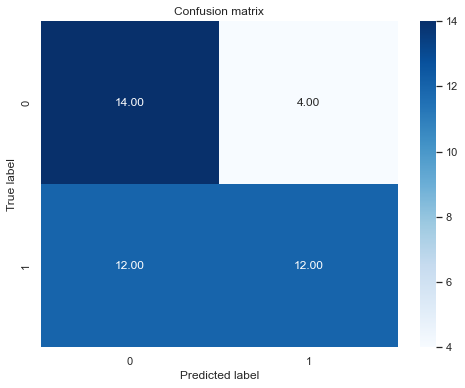

In [184]:
# Plot confusion matrix for test set
plot_confusion_matrix(xgb_model_tuned, X_test_scaled, y_test)